<a href="https://colab.research.google.com/github/dantrainor9/Cervical_cancer_risk_factors/blob/main/Project_2_Part_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
#risk factors affecting cervical cancer
path = '/content/drive/MyDrive/CodingDojo Data Science Bootcamp/07 Week 7 Logistic Regression and Regularization/risk_factors_cervical_cancer.csv'
df = pd.read_csv(path)
df.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,IUD (years),STDs,STDs (number),STDs:condylomatosis,STDs:cervical condylomatosis,STDs:vaginal condylomatosis,STDs:vulvo-perineal condylomatosis,STDs:syphilis,STDs:pelvic inflammatory disease,STDs:genital herpes,STDs:molluscum contagiosum,STDs:AIDS,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0
2,34,1.0,?,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0


In [ ]:
df.shape

(858, 36)

Multiple targets are present in the above dataset gathered from the UCI machine learning repository, as multiple diagnostic tools were used. However, as 'Biopsy' is the most common way of diagnosing cancer in the United States, I will be using that as my primary target after comparing the performance of the different diagnostic tests. 
This is a classification problem with 32 features.
There are 858 rows of data. 
I anticipate problems with missing data, as participants were not required to answer every question due to the sensitive nature of the survey.

In [ ]:
df = df.replace('?', np.nan)

In [ ]:
df.isna().sum()

Age                                     0
Number of sexual partners              26
First sexual intercourse                7
Num of pregnancies                     56
Smokes                                 13
Smokes (years)                         13
Smokes (packs/year)                    13
Hormonal Contraceptives               108
Hormonal Contraceptives (years)       108
IUD                                   117
IUD (years)                           117
STDs                                  105
STDs (number)                         105
STDs:condylomatosis                   105
STDs:cervical condylomatosis          105
STDs:vaginal condylomatosis           105
STDs:vulvo-perineal condylomatosis    105
STDs:syphilis                         105
STDs:pelvic inflammatory disease      105
STDs:genital herpes                   105
STDs:molluscum contagiosum            105
STDs:AIDS                             105
STDs:HIV                              105
STDs:Hepatitis B                  

In [ ]:
nulls = df.loc[df['STDs'].isna()]

In [ ]:
nulls

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,IUD (years),STDs,STDs (number),STDs:condylomatosis,STDs:cervical condylomatosis,STDs:vaginal condylomatosis,STDs:vulvo-perineal condylomatosis,STDs:syphilis,STDs:pelvic inflammatory disease,STDs:genital herpes,STDs:molluscum contagiosum,STDs:AIDS,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
71,34,NaN,NaN,3.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0,0,0,0,0,0,0
74,35,2.0,17.0,2.0,1.0,15.0,0.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0,0,0,0,0,0,0
90,36,1.0,13.0,6.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0,0,0,0,0,0,0
95,31,4.0,16.0,2.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0,0,0,0,0,0,0
98,31,1.0,20.0,5.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
792,23,3.0,15.0,1.0,1.0,5.0,0.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0,0,0,0,0,0,0
794,20,2.0,16.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0,0,0,0,0,0,0
807,36,2.0,18.0,NaN,1.0,19.0,7.6,1.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0,0,0,0,0,0,0
814,16,1.0,12.0,NaN,0.0,0.0,0.0,1.0,0.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0,0,0,0,0,0,1


In [ ]:
df_dropped = df.drop(nulls.index)
#dropping all of those who did not respond to the STD portion of the questionnaire.

In [ ]:
X = df_dropped[['Age', 
        'Number of sexual partners', 
        'First sexual intercourse', 
        'Num of pregnancies', 
        'Smokes', 
        'Smokes (years)', 
        'Smokes (packs/year)', 
        'Hormonal Contraceptives', 
        'Hormonal Contraceptives (years)', 
        'IUD', 
        'IUD (years)', 
        'STDs', 
        'STDs (number)', 
        'STDs:condylomatosis', 
        'STDs:vaginal condylomatosis', 
        'STDs:vulvo-perineal condylomatosis', 
        'STDs:syphilis', 
        'STDs:pelvic inflammatory disease', 
        'STDs:genital herpes', 
        'STDs:molluscum contagiosum', 
        'STDs:HIV',  
        'STDs:HPV', 
        'STDs: Number of diagnosis', 
        'Dx:Cancer', 
        'Dx:CIN', 
        'Dx:HPV', 
        'Dx']]
y = df_dropped['Biopsy']
#excluding 2 columns as features, time since first and last diagnosis of STDs
#excluding 3 columns as all participants answered the same, STDs: cervical condylomatosis, hepatitis B, and AIDS

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
mean_impute = SimpleImputer(strategy='mean')
mode_impute = SimpleImputer(strategy='most_frequent')

In [ ]:
X_train[['Smokes']] = mode_impute.fit_transform(X_train[['Smokes']])
#imputing mode, as this will either be smoking or non smoking, a binary option
#this will cause some error, as some people will be non smokers that this assumes are smokers, or vice versa

In [ ]:
X_train[['Smokes (years)', 'Smokes (packs/year)']] = mean_impute.fit_transform(X_train[['Smokes (years)', 'Smokes (packs/year)']])
#imputing mean, which will be above 0 (affected by years smoking and packs/year of smokers)
#but also affected by 0's (people who smoked 0 years and packs/year, non-smokers)
#this helps to neutralize the error caused in the previous step

In [ ]:
X_train[['Hormonal Contraceptives']] = mode_impute.fit_transform(X_train[['Hormonal Contraceptives']])
X_train[['Hormonal Contraceptives (years)']] = mean_impute.fit_transform(X_train[['Hormonal Contraceptives (years)']])
#reasoning same as above 2 cells

In [ ]:
X_train[['IUD']] = mode_impute.fit_transform(X_train[['IUD']])
X_train[['IUD (years)']] = mean_impute.fit_transform(X_train[['IUD (years)']])
#reasoning same as above 3 cells

In [ ]:
X_train[['Number of sexual partners', 'Num of pregnancies', 'First sexual intercourse']] = mode_impute.fit_transform(X_train[['Number of sexual partners', 'Num of pregnancies', 'First sexual intercourse']])
#imputing mode to avoid strong effects of outliers

In [ ]:
X_train.isna().sum()

Age                                   0
Number of sexual partners             0
First sexual intercourse              0
Num of pregnancies                    0
Smokes                                0
Smokes (years)                        0
Smokes (packs/year)                   0
Hormonal Contraceptives               0
Hormonal Contraceptives (years)       0
IUD                                   0
IUD (years)                           0
STDs                                  0
STDs (number)                         0
STDs:condylomatosis                   0
STDs:vaginal condylomatosis           0
STDs:vulvo-perineal condylomatosis    0
STDs:syphilis                         0
STDs:pelvic inflammatory disease      0
STDs:genital herpes                   0
STDs:molluscum contagiosum            0
STDs:HIV                              0
STDs:HPV                              0
STDs: Number of diagnosis             0
Dx:Cancer                             0
Dx:CIN                                0


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 564 entries, 222 to 108
Data columns (total 27 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 564 non-null    int64  
 1   Number of sexual partners           564 non-null    object 
 2   First sexual intercourse            564 non-null    object 
 3   Num of pregnancies                  564 non-null    object 
 4   Smokes                              564 non-null    object 
 5   Smokes (years)                      564 non-null    float64
 6   Smokes (packs/year)                 564 non-null    float64
 7   Hormonal Contraceptives             564 non-null    object 
 8   Hormonal Contraceptives (years)     564 non-null    float64
 9   IUD                                 564 non-null    object 
 10  IUD (years)                         564 non-null    float64
 11  STDs                                564 non

In [ ]:
X_train = X_train.astype('float')
#messy data types, fixing that

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 564 entries, 222 to 108
Data columns (total 27 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 564 non-null    float64
 1   Number of sexual partners           564 non-null    float64
 2   First sexual intercourse            564 non-null    float64
 3   Num of pregnancies                  564 non-null    float64
 4   Smokes                              564 non-null    float64
 5   Smokes (years)                      564 non-null    float64
 6   Smokes (packs/year)                 564 non-null    float64
 7   Hormonal Contraceptives             564 non-null    float64
 8   Hormonal Contraceptives (years)     564 non-null    float64
 9   IUD                                 564 non-null    float64
 10  IUD (years)                         564 non-null    float64
 11  STDs                                564 non

In [ ]:
#repeating steps for X_test
X_test[['Smokes']] = mode_impute.fit_transform(X_test[['Smokes']])
X_test[['Smokes (years)', 'Smokes (packs/year)']] = mean_impute.fit_transform(X_test[['Smokes (years)', 'Smokes (packs/year)']])
X_test[['Hormonal Contraceptives']] = mode_impute.fit_transform(X_test[['Hormonal Contraceptives']])
X_test[['Hormonal Contraceptives (years)']] = mean_impute.fit_transform(X_test[['Hormonal Contraceptives (years)']])
X_test[['IUD']] = mode_impute.fit_transform(X_test[['IUD']])
X_test[['IUD (years)']] = mean_impute.fit_transform(X_test[['IUD (years)']])
X_test[['Number of sexual partners', 'Num of pregnancies', 'First sexual intercourse']] = mode_impute.fit_transform(X_test[['Number of sexual partners', 'Num of pregnancies', 'First sexual intercourse']])


In [ ]:
X_test = X_test.astype('float')

In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189 entries, 821 to 24
Data columns (total 27 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 189 non-null    float64
 1   Number of sexual partners           189 non-null    float64
 2   First sexual intercourse            189 non-null    float64
 3   Num of pregnancies                  189 non-null    float64
 4   Smokes                              189 non-null    float64
 5   Smokes (years)                      189 non-null    float64
 6   Smokes (packs/year)                 189 non-null    float64
 7   Hormonal Contraceptives             189 non-null    float64
 8   Hormonal Contraceptives (years)     189 non-null    float64
 9   IUD                                 189 non-null    float64
 10  IUD (years)                         189 non-null    float64
 11  STDs                                189 non-

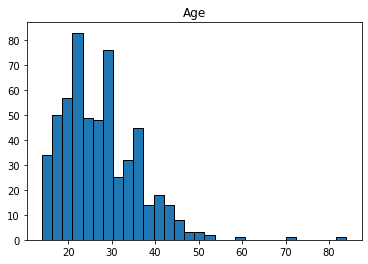

In [ ]:
plt.hist(X_train['Age'], bins=30, edgecolor='k')
plt.title('Age');
#looks like an outlier here, at least one much older participant

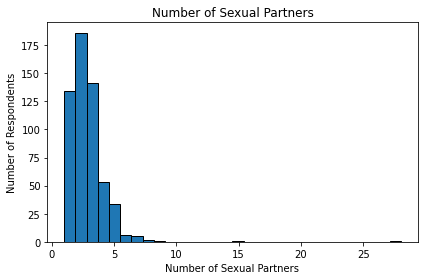

In [ ]:
plt.hist(X_train['Number of sexual partners'], bins=30, edgecolor='k')
plt.title('Number of Sexual Partners')
plt.xlabel('Number of Sexual Partners')
plt.ylabel('Number of Respondents')
plt.tight_layout()
plt.savefig('NumberofSexualPartners.png', dpi = 300);
#some outliers here as well

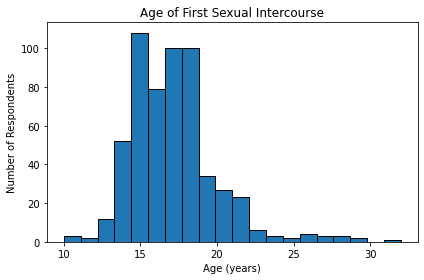

In [ ]:
plt.hist(X_train['First sexual intercourse'], bins=20, edgecolor='k')
plt.title('Age of First Sexual Intercourse')
plt.xlabel('Age (years)')
plt.ylabel('Number of Respondents')
plt.tight_layout()
plt.savefig('AgeofFirstSexualIntercourse.png', dpi = 300);
#fairly normal with a bit of a right skew

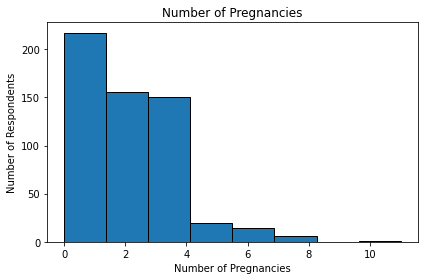

In [ ]:
plt.hist(X_train['Num of pregnancies'], bins=8, edgecolor='k')
plt.title('Number of Pregnancies')
plt.xlabel('Number of Pregnancies')
plt.ylabel('Number of Respondents')
plt.tight_layout()
plt.savefig('NumberofPregnancies.png', dpi = 300);
#right skew here

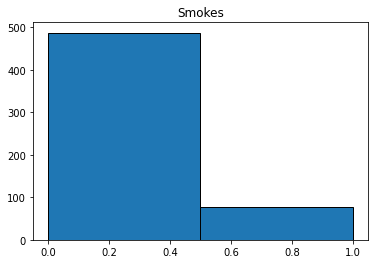

In [ ]:
plt.hist(X_train['Smokes'], bins=2, edgecolor='k')
plt.title('Smokes');

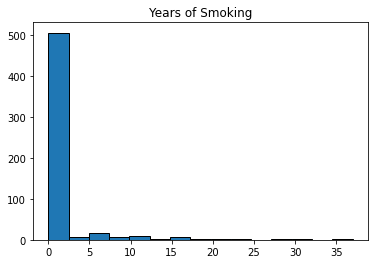

In [ ]:
plt.hist(X_train['Smokes (years)'], bins=15, edgecolor='k')
plt.title('Years of Smoking');
#right skew, though most of these probably count as outliers as most participants were non-smokers

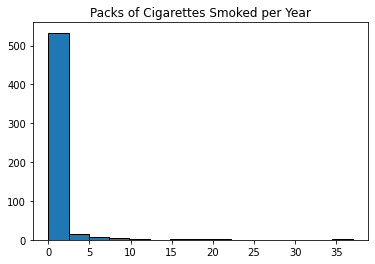

In [ ]:
plt.hist(X_train['Smokes (packs/year)'], bins=15, edgecolor='k')
plt.title('Packs of Cigarettes Smoked per Year');
#similar skew to the graph above

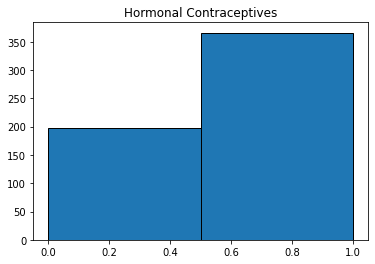

In [ ]:
plt.hist(X_train['Hormonal Contraceptives'], bins=2, edgecolor='k')
plt.title('Hormonal Contraceptives');
#more common for our participants to have taken hormonal contraceptives than not

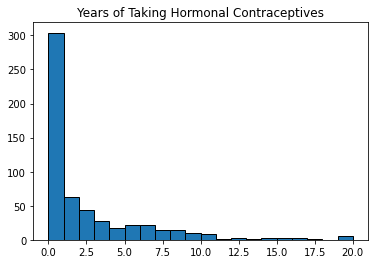

In [ ]:
plt.hist(X_train['Hormonal Contraceptives (years)'], bins=20, edgecolor='k')
plt.title('Years of Taking Hormonal Contraceptives');
#right skew with some outliers

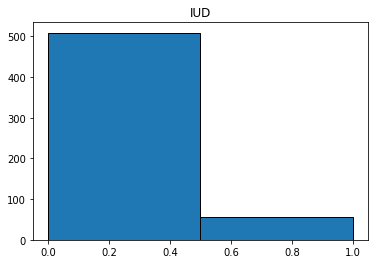

In [ ]:
plt.hist(X_train['IUD'], bins=2, edgecolor='k')
plt.title('IUD');
#IUD is much less common than hormonal contraceptives in our dataset

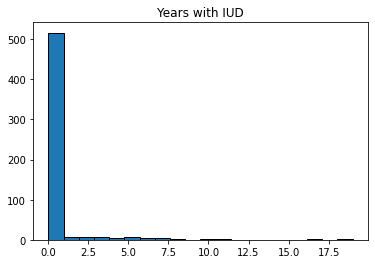

In [ ]:
plt.hist(X_train['IUD (years)'], bins=20, edgecolor='k')
plt.title('Years with IUD');
#with so few IUD users, most on the tail of this skew are likely outliers

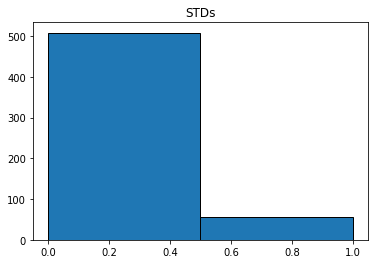

In [ ]:
plt.hist(X_train['STDs'], bins=2, edgecolor='k')
plt.title('STDs');
#STDs are uncommon it seems, or at least not commonly admitted to

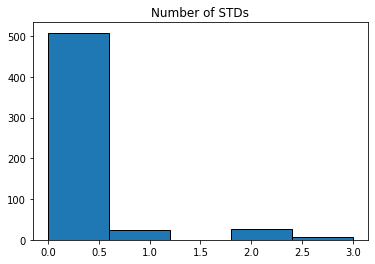

In [ ]:
plt.hist(X_train['STDs (number)'], bins=5, edgecolor='k')
plt.title('Number of STDs');
#also more common to disclose fewer than 3

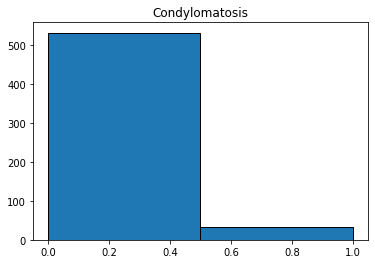

In [ ]:
plt.hist(X_train['STDs:condylomatosis'], bins=2, edgecolor='k')
plt.title('Condylomatosis');

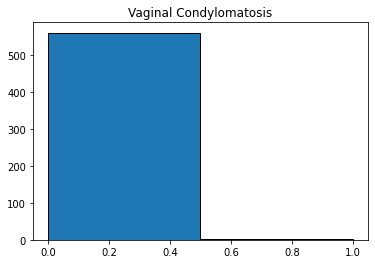

In [ ]:
plt.hist(X_train['STDs:vaginal condylomatosis'], bins=2, edgecolor='k')
plt.title('Vaginal Condylomatosis');

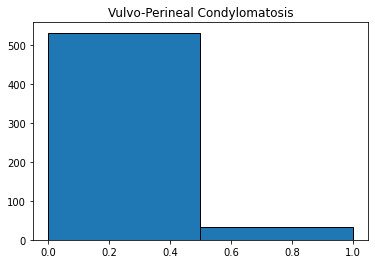

In [ ]:
plt.hist(X_train['STDs:vulvo-perineal condylomatosis'], bins=2, edgecolor='k')
plt.title('Vulvo-Perineal Condylomatosis');

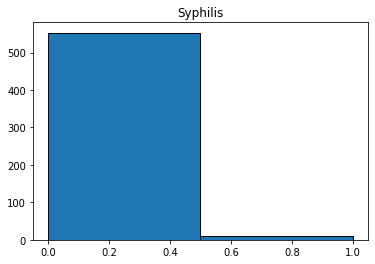

In [ ]:
plt.hist(X_train['STDs:syphilis'], bins=2, edgecolor='k')
plt.title('Syphilis');

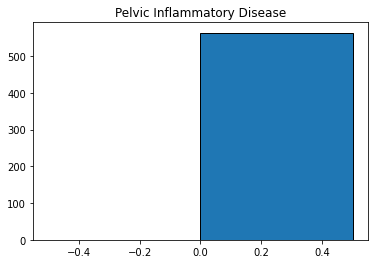

In [ ]:
plt.hist(X_train['STDs:pelvic inflammatory disease'], bins=2, edgecolor='k')
plt.title('Pelvic Inflammatory Disease');

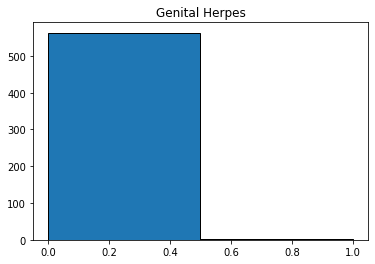

In [ ]:
plt.hist(X_train['STDs:genital herpes'], bins=2, edgecolor='k')
plt.title('Genital Herpes');

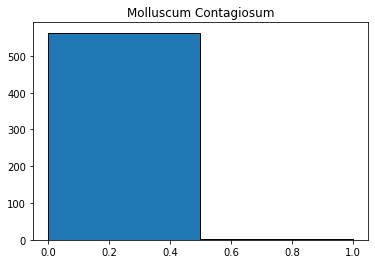

In [ ]:
plt.hist(X_train['STDs:molluscum contagiosum'], bins=2, edgecolor='k')
plt.title('Molluscum Contagiosum');

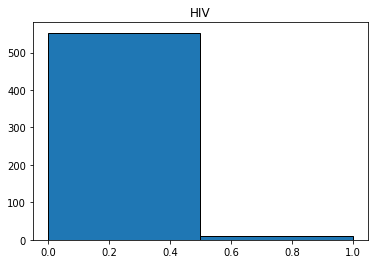

In [ ]:
plt.hist(X_train['STDs:HIV'], bins=2, edgecolor='k')
plt.title('HIV');
#still some with HIV, however, this does not necessarily confound their data

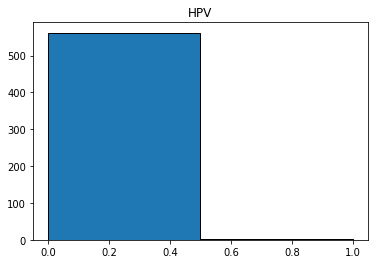

In [ ]:
plt.hist(X_train['STDs:HPV'], bins=2, edgecolor='k')
plt.title('HPV');

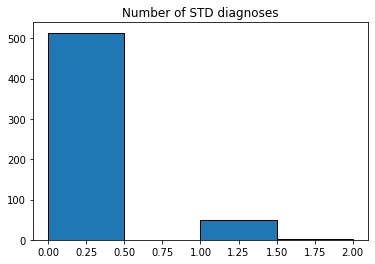

In [ ]:
plt.hist(X_train['STDs: Number of diagnosis'], bins=4, edgecolor='k')
plt.title('Number of STD diagnoses');
#looks like anyone who answered more than 1 is an outlier in this column

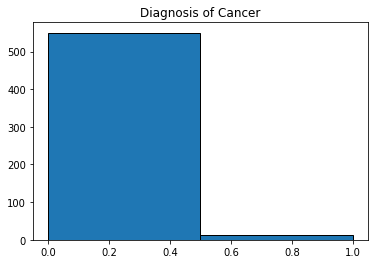

In [ ]:
plt.hist(X_train['Dx:Cancer'], bins=2, edgecolor='k')
plt.title('Diagnosis of Cancer');

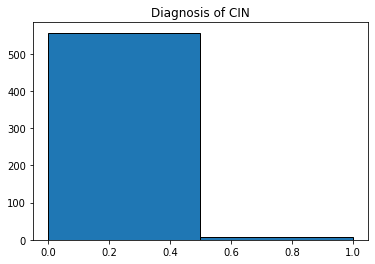

In [ ]:
plt.hist(X_train['Dx:CIN'], bins=2, edgecolor='k')
plt.title('Diagnosis of CIN');

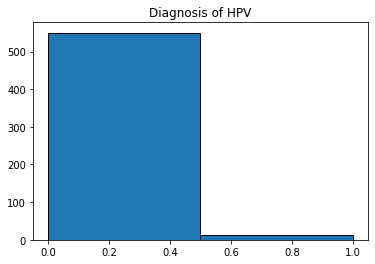

In [ ]:
plt.hist(X_train['Dx:HPV'], bins=2, edgecolor='k')
plt.title('Diagnosis of HPV');

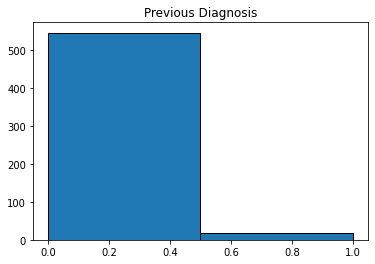

In [ ]:
plt.hist(X_train['Dx'], bins=2, edgecolor='k')
plt.title('Previous Diagnosis');

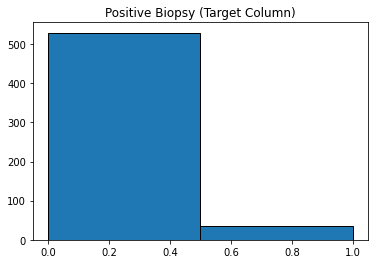

In [ ]:
plt.hist(y_train, bins=2, edgecolor='k')
plt.title('Positive Biopsy (Target Column)');
#target column

In [ ]:
X_train['Biopsy'] = y_train
#re-adding the target column for checking correlations

In [ ]:
train_corr = X_train.corr()

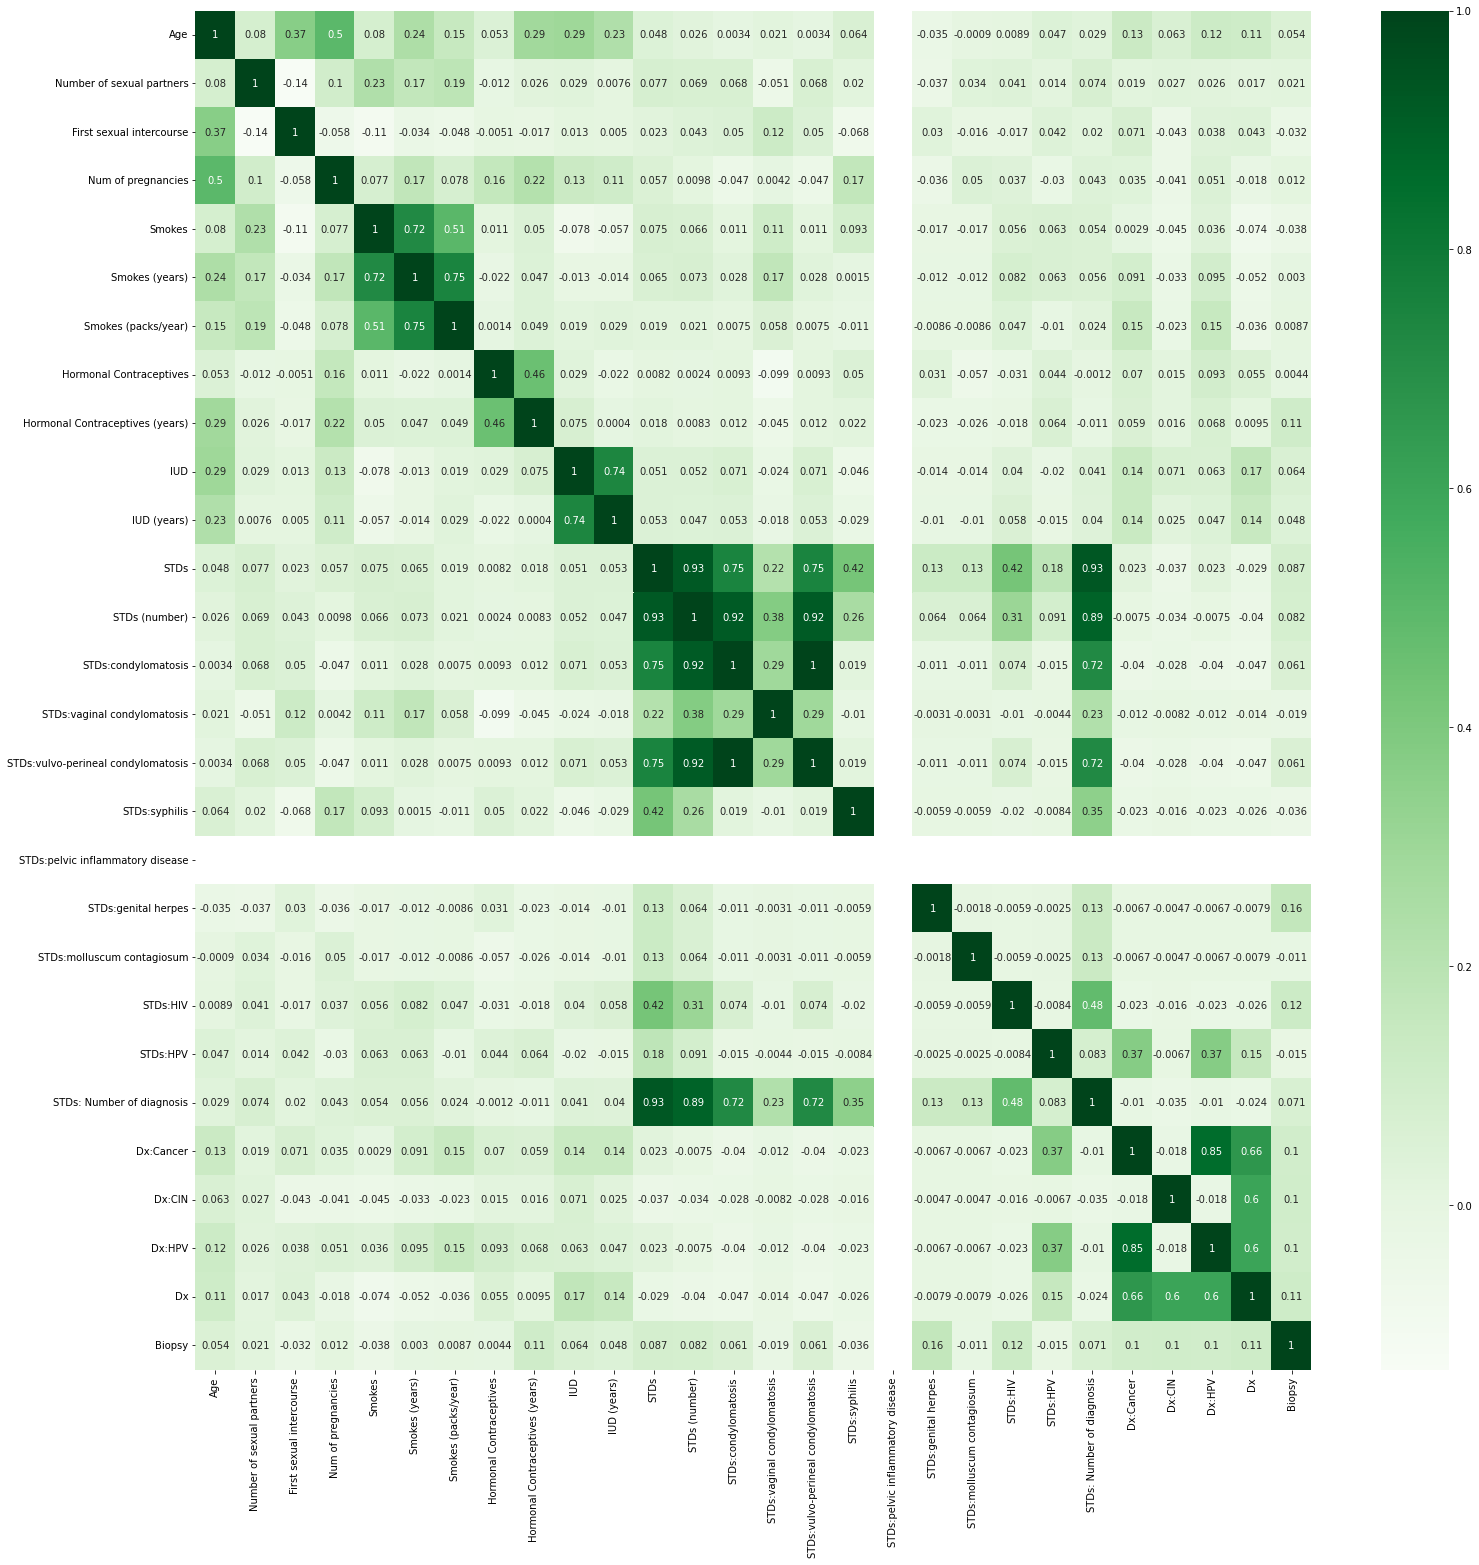

In [ ]:
plt.figure(figsize=(25,25))
sns.heatmap(data=train_corr, cmap='Greens', annot=True);

In [ ]:
#no strong or moderate correlations with the target column.
#with this low of a correlation rate, I may need to add back in the 105 participants I dropped earlier.

In [ ]:
X_train = X_train.drop(columns=['Biopsy'])

In [ ]:
scaler = StandardScaler()

In [ ]:
xgb = XGBClassifier()

In [ ]:
xgb_pipe = make_pipeline(scaler, xgb)

In [ ]:
xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbclassifier', XGBClassifier())])

In [ ]:
xgb_preds = xgb_pipe.predict(X_test)

In [ ]:
print(classification_report(y_test,xgb_preds))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       171
           1       0.50      0.06      0.10        18

    accuracy                           0.90       189
   macro avg       0.70      0.52      0.52       189
weighted avg       0.87      0.90      0.87       189



In [ ]:
rf = RandomForestClassifier()

In [ ]:
rf_pipe = make_pipeline(scaler,rf)

In [ ]:
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier', RandomForestClassifier())])

In [ ]:
rf_preds = rf_pipe.predict(X_test)

In [ ]:
print(classification_report(y_test,rf_preds))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95       171
           1       0.00      0.00      0.00        18

    accuracy                           0.90       189
   macro avg       0.45      0.50      0.48       189
weighted avg       0.82      0.90      0.86       189



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
lgb = LGBMClassifier()

In [ ]:
lgb_pipe = make_pipeline(scaler,lgb)

In [ ]:
lgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lgbmclassifier', LGBMClassifier())])

In [ ]:
lgb_preds = lgb_pipe.predict(X_test)

In [ ]:
print(classification_report(y_test, lgb_preds))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94       171
           1       0.25      0.06      0.09        18

    accuracy                           0.89       189
   macro avg       0.58      0.52      0.52       189
weighted avg       0.85      0.89      0.86       189



As XGBClassifier is the only model to return a decent probability of the 1 class, I will be using this as the production model

In [ ]:
xgb_pipe.get_params()

{'memory': None,
 'standardscaler': StandardScaler(),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'steps': [('standardscaler', StandardScaler()),
  ('xgbclassifier', XGBClassifier())],
 'verbose': False,
 'xgbclassifier': XGBClassifier(),
 'xgbclassifier__base_score': 0.5,
 'xgbclassifier__booster': 'gbtree',
 'xgbclassifier__colsample_bylevel': 1,
 'xgbclassifier__colsample_bynode': 1,
 'xgbclassifier__colsample_bytree': 1,
 'xgbclassifier__gamma': 0,
 'xgbclassifier__learning_rate': 0.1,
 'xgbclassifier__max_delta_step': 0,
 'xgbclassifier__max_depth': 3,
 'xgbclassifier__min_child_weight': 1,
 'xgbclassifier__missing': None,
 'xgbclassifier__n_estimators': 100,
 'xgbclassifier__n_jobs': 1,
 'xgbclassifier__nthread': None,
 'xgbclassifier__objective': 'binary:logistic',
 'xgbclassifier__random_state': 0,
 'xgbclassifier__reg_alpha': 0,
 'xgbclassifier__reg_lambda': 1,
 'xgbclassifier__scale_pos_weight': 1,
 'xgbclassifier__se

In [ ]:
params = {'xgbclassifier__n_estimators':[75,100,200,300],
          'xgbclassifier__max_depth':[2,3,5,7,10],
          'xgbclassifier__min_child_weight':[1,3,5,7],
          'xgbclassifier__learning_rate':[0.01,0.05,0.1,0.2],
          'xgbclassifier__gamma':[0,0.05,0.1,0.2,0.5]}

In [ ]:
grid = GridSearchCV(xgb_pipe,params)

In [ ]:
grid.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('xgbclassifier', XGBClassifier())]),
             param_grid={'xgbclassifier__gamma': [0, 0.05, 0.1, 0.2, 0.5],
                         'xgbclassifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'xgbclassifier__max_depth': [2, 3, 5, 7, 10],
                         'xgbclassifier__min_child_weight': [1, 3, 5, 7],
                         'xgbclassifier__n_estimators': [75, 100, 200, 300]})

In [ ]:
print(grid.best_params_)

{'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__max_depth': 2, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__n_estimators': 75}


In [ ]:
best_xgb = XGBClassifier(learning_rate=.01,n_estimators=75, max_depth=2)

In [ ]:
best_xgb_pipe = make_pipeline(scaler,best_xgb)

In [ ]:
best_xgb_pipe.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbclassifier',
                 XGBClassifier(learning_rate=0.01, max_depth=2,
                               n_estimators=75))])

In [ ]:
best_xgb_preds = best_xgb_pipe.predict(X_test)

In [ ]:
print(classification_report(y_test,best_xgb_preds))

              precision    recall  f1-score   support

           0       0.90      0.99      0.95       171
           1       0.00      0.00      0.00        18

    accuracy                           0.90       189
   macro avg       0.45      0.50      0.47       189
weighted avg       0.82      0.90      0.86       189



After trying out a few different models, I tried running a GridSearchCV to find the best hyperparameters for tuning XGBClassifier. The tuned hyperparamters lead to improved predictions of the false class, but worse predictions of the true class. This is dangerous for a cancer classification, as false negatives could lead to cancer going untreated.